In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [49]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', data_name='fem_box', frequency=80, xyz_slice='2D')
data

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Single frequency 2D
<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    spatial_region  (x, y) int64 

<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
    spatial_region  (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    Lu              (frequency, x, y, component) complex128 (-0.0057547091471...
    Mu              (frequency, x, y) complex128 (3768.976611513677-1443.9860...

<IPython.core.display.Javascript object>


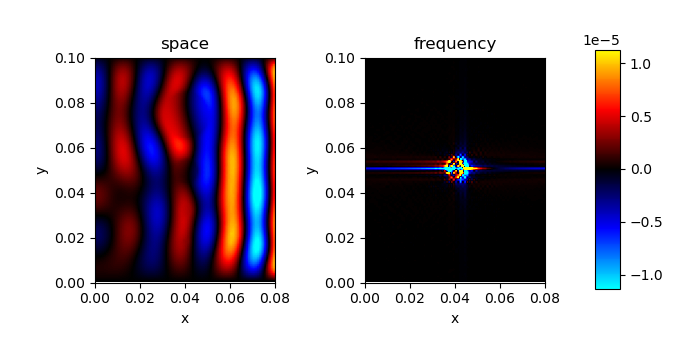

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


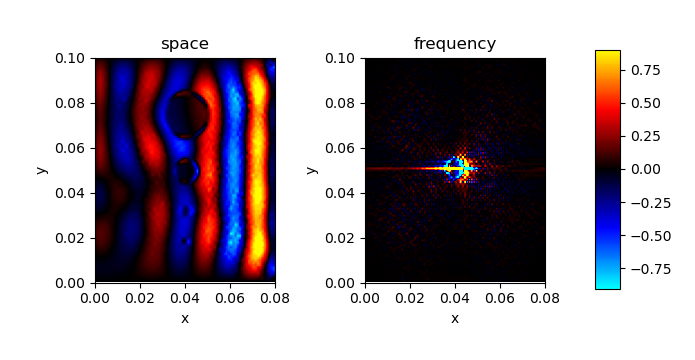

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


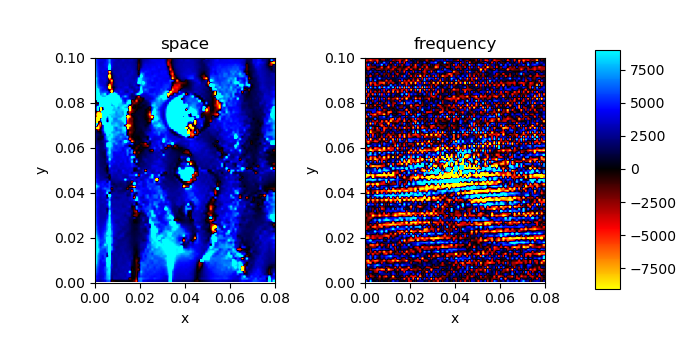

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


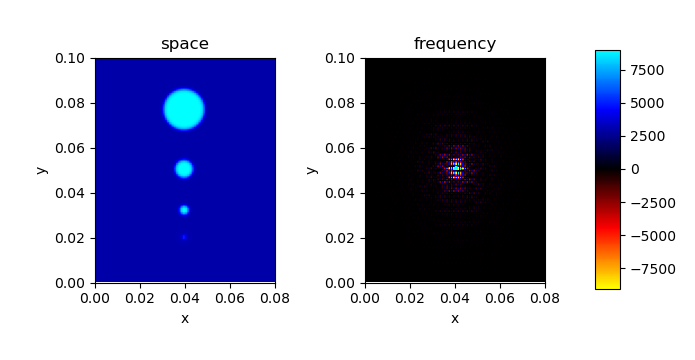

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

In [100]:
%autoreload

# configure color maps
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
elast_kws = mre_pinn.visual.get_color_kws(data.mu)

# display true wave field and elastogram
y = 'y' if 'y' in data.field.spatial_dims else None
hue = None if 'y' in data.field.spatial_dims else 'part'
mre_pinn.visual.XArrayViewer(data.u,  col='domain', y=y, hue=None, ax_width=2, **wave_kws)
mre_pinn.visual.XArrayViewer(data.Lu, col='domain', y=y, hue=None, ax_width=2, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu.mean('frequency'), col='domain', y=y, hue=None, ax_width=2, **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu.mean('frequency'), col='domain', y=y, hue=None, ax_width=2, **elast_kws)

In [53]:
# convert to vector/scalar fields and coordinates
x  = data.u.field.points().astype(np.float32)
u  = data.u.field.values().astype(np.complex64)
mu = data.mu.field.values().astype(np.complex64)

print('x ', type(x), x.shape, x.dtype)
print('u ', type(u), u.shape, u.dtype)
print('mu', type(mu), mu.shape, mu.dtype)

x  <class 'numpy.ndarray'> (8000, 3) float32
u  <class 'numpy.ndarray'> (8000, 2) complex64
mu <class 'numpy.ndarray'> (8000, 1) complex64


In [54]:
%autoreload

# initialize the PDE, geometry, and boundary conditions
pde = mre_pinn.pde.WaveEquation.from_name('hetero', detach=True)
geom = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + 1e-5)
#geom = deepxde.geometry.PointCloud(x)
bc = mre_pinn.fields.VectorFieldBC(x, u)

In [88]:
%autoreload

# define model architecture

net = mre_pinn.model.MREPINN(
    input=x,
    outputs=[u, mu],
    omega0=16,
    n_layers=5,
    n_hidden=128,
    activ_fn='t',
    parallel=True,
    dense=True,
    dtype=torch.float32
)

net

MREPINN(
  (0): InputScaler()
  (1): Parallel(
    (0): FFNN(
      (linear0_tanh): Linear(in_features=3, out_features=128, bias=True)
      (linear1_tanh): Linear(in_features=131, out_features=128, bias=True)
      (linear2_tanh): Linear(in_features=259, out_features=128, bias=True)
      (linear3_tanh): Linear(in_features=387, out_features=128, bias=True)
      (linear4): Linear(in_features=515, out_features=4, bias=True)
    )
    (1): FFNN(
      (linear0_tanh): Linear(in_features=3, out_features=128, bias=True)
      (linear1_tanh): Linear(in_features=131, out_features=128, bias=True)
      (linear2_tanh): Linear(in_features=259, out_features=128, bias=True)
      (linear3_tanh): Linear(in_features=387, out_features=128, bias=True)
      (linear4): Linear(in_features=515, out_features=2, bias=True)
    )
  )
  (2): RealToComplex()
  (3): OutputScaler()
)

In [89]:
model = mre_pinn.training.MREPINNModel(
    net, pde, geom, bc,
    batch_size=80,
    num_domain=128 - 80,
    num_boundary=0,
    train_distribution='pseudo',
    anchors=None
)

x [[8.0000000e+01 3.9499987e-02 4.9500085e-02]] [[0.     0.0395 0.0495]]
u [[-9.183170e-08-8.3213047e-07j -2.577481e-09-8.8405780e-09j]] [[6.1520532e-06 3.6243864e-07]]
mu [[3239.4297+502.65485j]] [[1106.456]]
lu [[-0.00046626 -0.00016354]] [[0.27609095 0.0165126 ]]


<IPython.core.display.Javascript object>


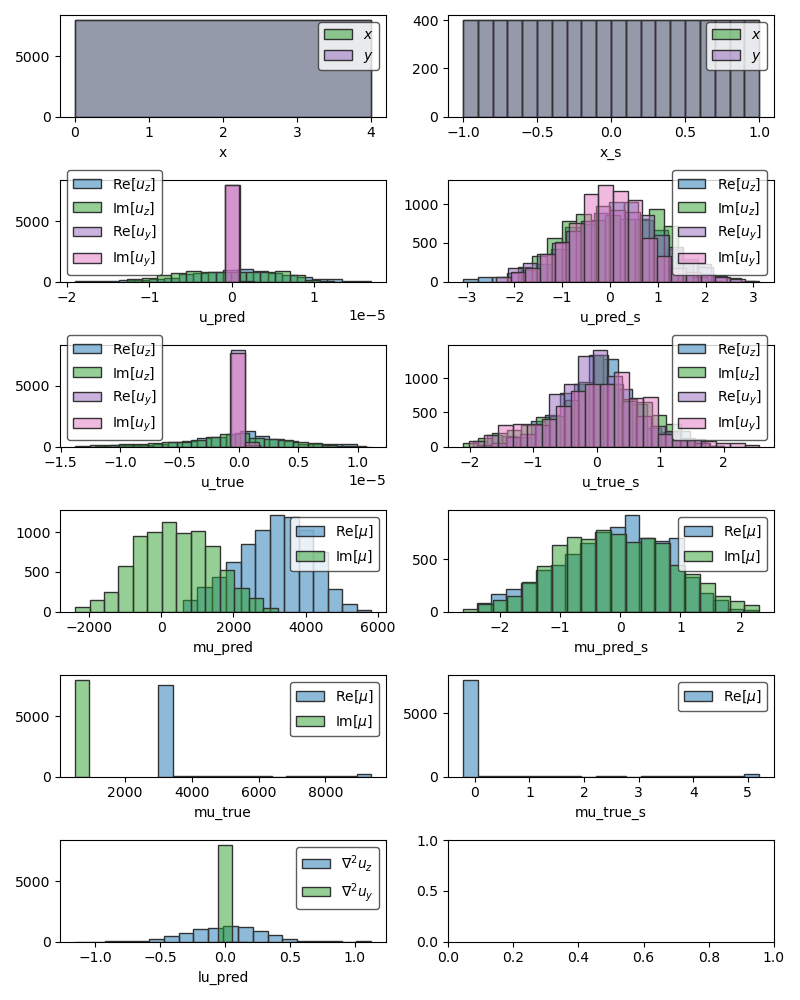

In [57]:
# descriptive statistics

%autoreload

kws = dict(axis=0, keepdims=True)

# standardize input to [-1, 1]
x_loc = x.mean(**kws)
x_scale = (x.max(**kws) - x.min(**kws)) / 2
print('x', x_loc, x_scale)

# avoid division by zero
x_scale[x_scale == 0] = 1
x_s = (x - x_loc) / x_scale

# test forward pass
u_pred, lu_pred, mu_pred, f_trac, f_body = model.predict(x, batch_size=128)
pde_res = f_trac + f_body

u_pred = u_pred.detach().cpu().numpy()
lu_pred = lu_pred.detach().cpu().numpy()
mu_pred = mu_pred.detach().cpu().numpy()

# normalize outputs via mean and std
u_loc = u.mean(**kws)
u_scale = u.std(**kws)
print('u', u_loc, u_scale)

u_s = (u - u_loc) / u_scale
u_pred_s = (u_pred - u_loc) / u_scale

mu_loc = mu.mean(**kws)
mu_scale = mu.std(**kws)
print('mu', mu_loc, mu_scale)

mu_s = (mu - mu_loc) / mu_scale
mu_pred_s = (mu_pred - mu_loc) / mu_scale

# compute laplacian statistics
lu_loc = lu_pred.mean(**kws)
lu_scale = lu_pred.std(**kws)
print('lu', lu_loc, lu_scale)

# display input and output distributions

def hex_to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def plot_hist(ax, a, xlabel, hue=None):
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a)
    bin_width = (a.max() - a.min()) / 20
    for a, hue in zip(a.T, hue):
        bins = np.arange(a.min(), a.max() + bin_width, bin_width)
        color = next(ax._get_lines.prop_cycler)["color"]
        ax.hist(a, bins=bins, label=hue, edgecolor='0.2', fc=color + '80')
    ax.set_xlabel(xlabel)
    ax.legend(frameon=True, edgecolor='0.2')

fig, axes = plt.subplots(6, 2, figsize=(8, 10))

ndim = len(data.u.field.spatial_dims)
x_hues = ['$\omega$', '$x$', '$y$', '$z$'][:ndim+1]
plot_hist(axes[0,0], x,   hue=x_hues, xlabel='x')
plot_hist(axes[0,1], x_s, hue=x_hues, xlabel='x_s')

u_hues = ['$u_z$', '$u_y$', '$u_x$'][:ndim]
u_hues = [p.format(h) for h in u_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[1,0], u_pred,   hue=u_hues, xlabel='u_pred')
plot_hist(axes[1,1], u_pred_s, hue=u_hues, xlabel='u_pred_s')

plot_hist(axes[2,0], u,   hue=u_hues, xlabel='u_true')
plot_hist(axes[2,1], u_s, hue=u_hues, xlabel='u_true_s')

mu_hues = ['Re[$\mu$]', 'Im[$\mu$]']
plot_hist(axes[3,0], mu_pred,   hue=mu_hues, xlabel='mu_pred')
plot_hist(axes[3,1], mu_pred_s, hue=mu_hues, xlabel='mu_pred_s')

plot_hist(axes[4,0], mu,   hue=mu_hues, xlabel='mu_true')
plot_hist(axes[4,1], mu_s, hue=mu_hues, xlabel='mu_true_s')

lu_hues = ['$\\nabla^2 u_z$', '$\\nabla^2 u_y$', '$\nabla^2 u_x$'][:ndim]
#lu_hues = [p.format(h) for h in lu_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[5,0], lu_pred, hue=lu_hues, xlabel='lu_pred')

fig.tight_layout()

Compiling model...
'compile' took 0.000235 s

Training model...



<IPython.core.display.Javascript object>


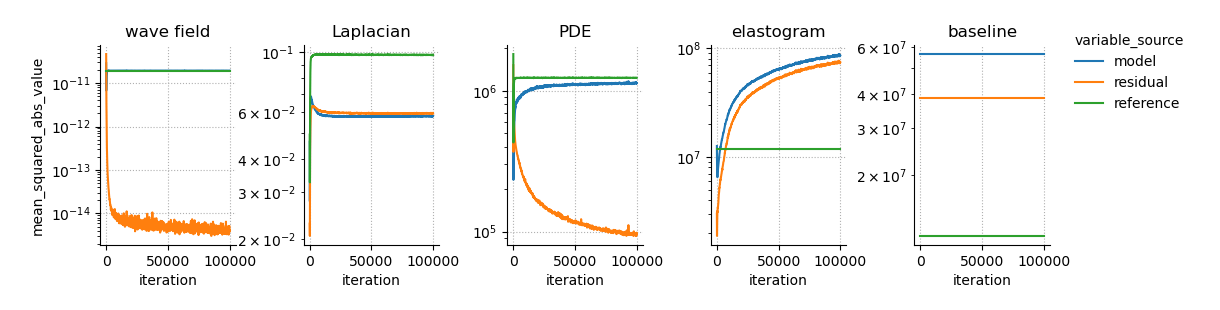

<IPython.core.display.Javascript object>


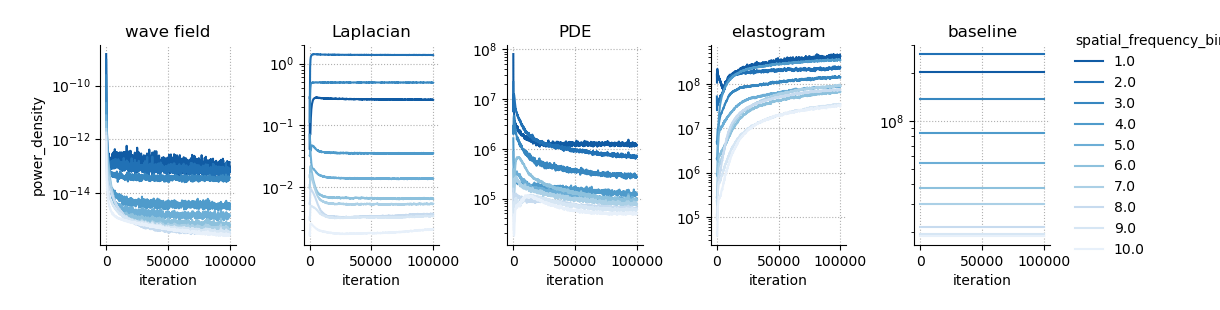

<IPython.core.display.Javascript object>


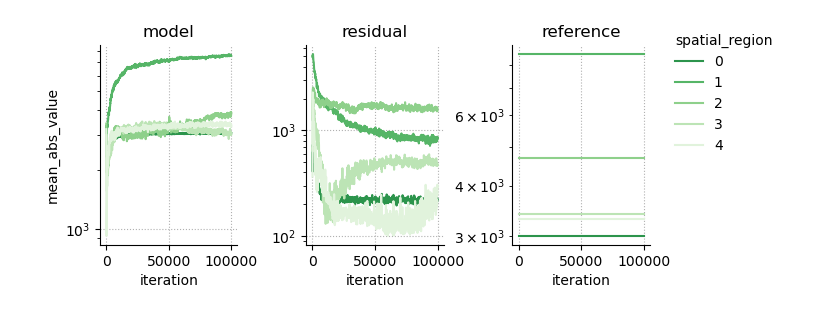

<IPython.core.display.Javascript object>


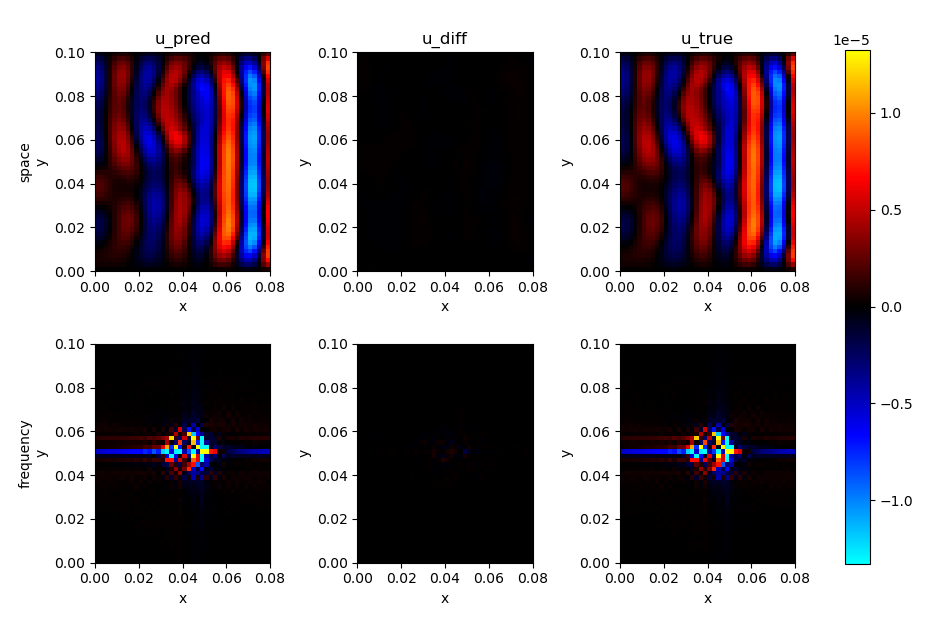

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


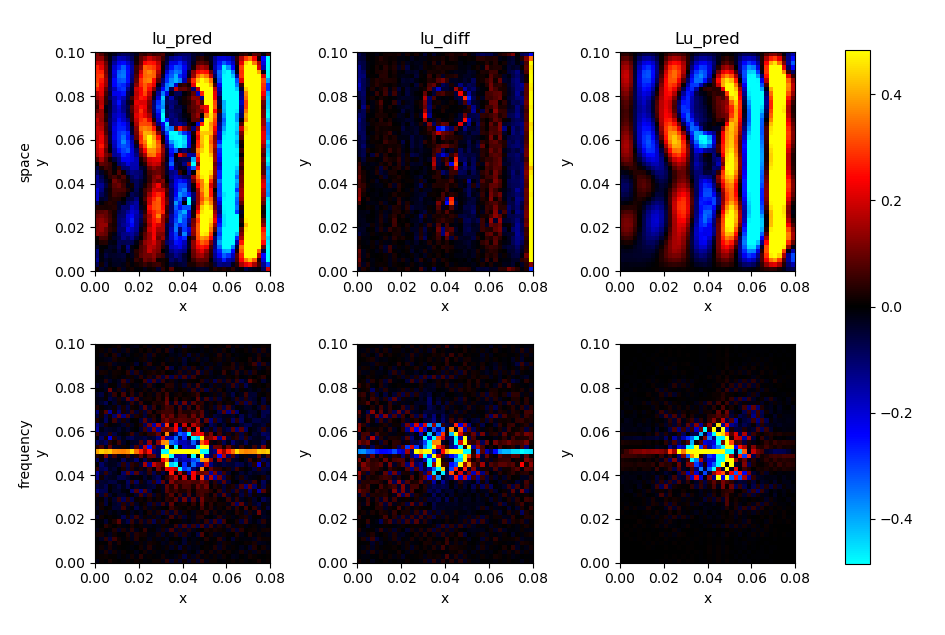

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


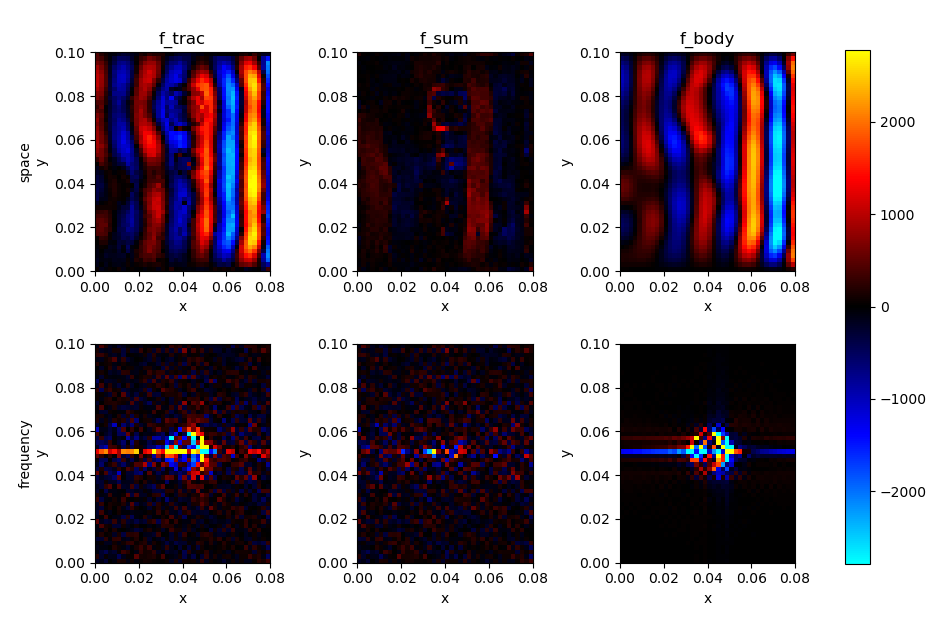

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


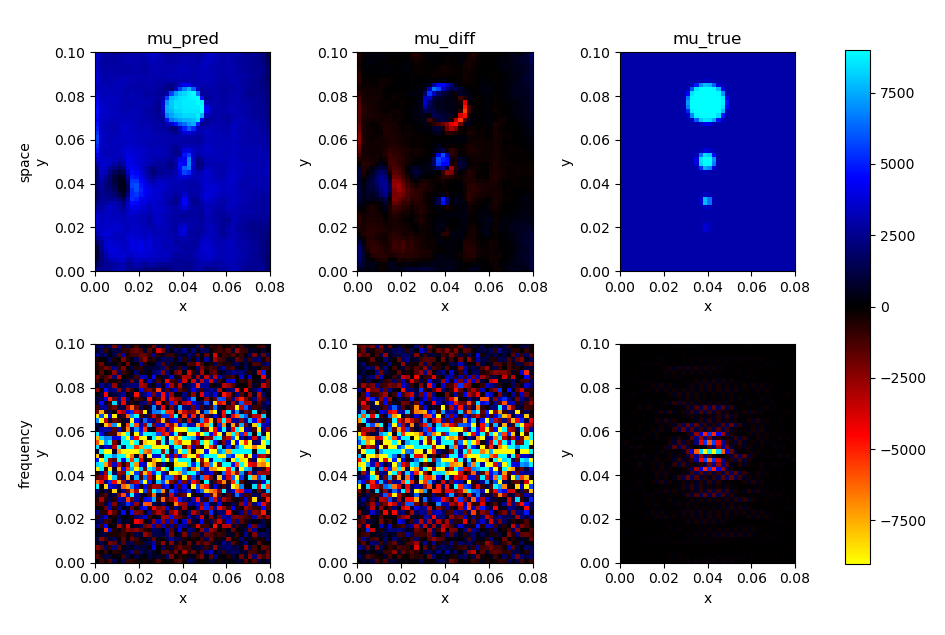

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


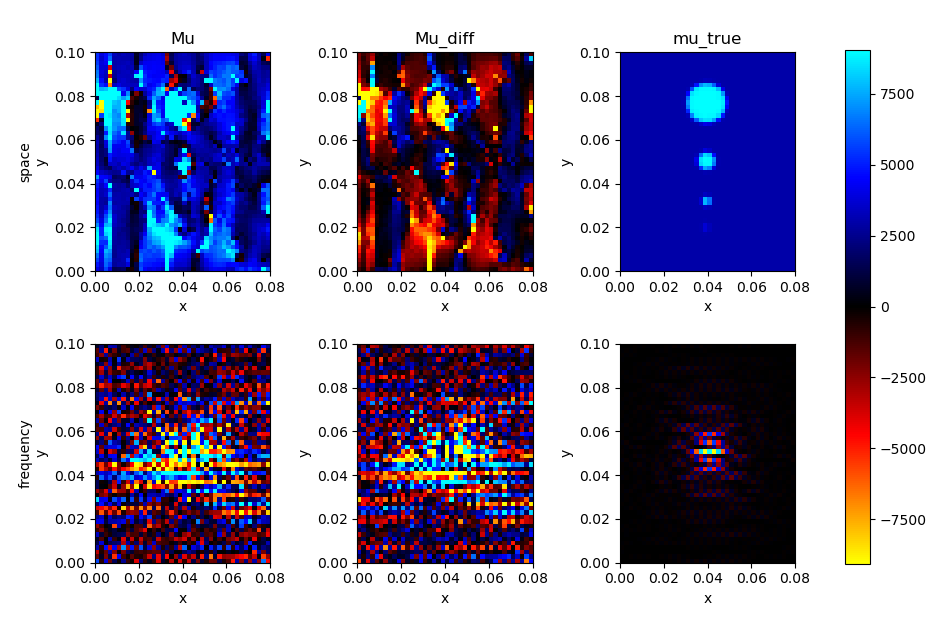

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

Time spent testing: 57.20%
Time spent testing: 49.71%
Time spent testing: 46.57%
Time spent testing: 44.84%
Time spent testing: 43.77%
Time spent testing: 43.03%
Time spent testing: 42.50%
Time spent testing: 42.07%
Time spent testing: 41.74%
Time spent testing: 41.48%
Time spent testing: 41.29%
Time spent testing: 41.12%
Time spent testing: 40.98%
Time spent testing: 40.86%
Time spent testing: 40.75%
Time spent testing: 40.65%
Time spent testing: 40.58%
Time spent testing: 40.51%
Time spent testing: 40.45%
Time spent testing: 40.52%
Time spent testing: 40.58%
Time spent testing: 40.63%
Time spent testing: 41.08%
Time spent testing: 41.11%
Time spent testing: 41.13%
Time spent testing: 41.17%
Time spent testing: 41.20%
Time spent testing: 41.22%
Time spent testing: 41.24%
Time spent testing: 41.26%
Time spent testing: 41.28%
Time spent testing: 41.30%
Time spent testing: 41.31%
Time spent testing: 41.34%
Time spent testing: 41.36%
Time spent testing: 41.38%
Time spent testing: 41.40%
T

Time spent testing: 45.70%
Time spent testing: 45.71%
Time spent testing: 45.73%
Time spent testing: 45.75%
Time spent testing: 45.77%
Time spent testing: 45.78%
Time spent testing: 45.80%
Time spent testing: 45.82%
Time spent testing: 45.87%
Time spent testing: 45.89%
Time spent testing: 45.92%
Time spent testing: 45.94%
Time spent testing: 45.97%
Time spent testing: 45.99%
Time spent testing: 46.02%
Time spent testing: 46.04%
Time spent testing: 46.07%
Time spent testing: 46.09%
Time spent testing: 46.12%
Time spent testing: 46.14%
Time spent testing: 46.19%
Time spent testing: 46.21%
Time spent testing: 46.23%
Time spent testing: 46.26%
Time spent testing: 46.28%
Time spent testing: 46.30%
Time spent testing: 46.33%
Time spent testing: 46.35%
Time spent testing: 46.38%
Time spent testing: 46.40%
Time spent testing: 46.42%
Time spent testing: 46.47%
Time spent testing: 46.49%
Time spent testing: 46.52%
Time spent testing: 46.54%
Time spent testing: 46.56%
Time spent testing: 46.59%
T

Time spent testing: 52.26%
Time spent testing: 52.30%
Time spent testing: 52.32%
Time spent testing: 52.35%
Time spent testing: 52.37%
Time spent testing: 52.39%
Time spent testing: 52.41%
Time spent testing: 52.45%
Time spent testing: 52.47%
Time spent testing: 52.49%
Time spent testing: 52.51%
Time spent testing: 52.53%
Time spent testing: 52.55%
Time spent testing: 52.58%
Time spent testing: 52.60%
Time spent testing: 52.61%
Time spent testing: 52.63%
Time spent testing: 52.65%
Time spent testing: 52.67%
Time spent testing: 52.69%
Time spent testing: 52.72%
Time spent testing: 52.73%
Time spent testing: 52.75%
Time spent testing: 52.77%
Time spent testing: 52.79%
Time spent testing: 52.81%
Time spent testing: 52.84%
Time spent testing: 52.85%
Time spent testing: 52.87%
Time spent testing: 52.89%
Time spent testing: 52.91%
Time spent testing: 52.93%
Time spent testing: 52.96%
Time spent testing: 52.97%
Time spent testing: 52.99%
Time spent testing: 53.01%
Time spent testing: 53.03%
T

Time spent testing: 57.69%
Time spent testing: 57.70%
Time spent testing: 57.72%
Time spent testing: 57.74%
Time spent testing: 57.76%
Time spent testing: 57.77%
Time spent testing: 57.79%
Time spent testing: 57.80%
Time spent testing: 57.82%
Time spent testing: 57.84%
Time spent testing: 57.86%
Time spent testing: 57.87%
Time spent testing: 57.89%
Time spent testing: 57.91%
Time spent testing: 57.92%
Time spent testing: 57.94%
Time spent testing: 57.95%
Time spent testing: 57.97%
Time spent testing: 57.99%
Time spent testing: 58.00%
Time spent testing: 58.01%
Time spent testing: 58.03%
Time spent testing: 58.04%
Time spent testing: 58.06%
Time spent testing: 58.07%
Time spent testing: 58.09%
Time spent testing: 58.11%
Time spent testing: 58.12%
Time spent testing: 58.14%
Time spent testing: 58.15%
Time spent testing: 58.17%
Time spent testing: 58.19%
Time spent testing: 58.20%
Time spent testing: 58.22%
Time spent testing: 58.23%
Time spent testing: 58.25%
Time spent testing: 58.26%
T

In [90]:
%autoreload

model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1e-8, 1],
    loss=mre_pinn.training.standardized_msae_loss_fn(u)
)
deepxde.display.training_display = mre_pinn.training.SummaryDisplay()
callbacks = [
    mre_pinn.training.TestEvaluation(test_data, batch_size=128, test_every=100, save_every=1000, interact=True),
    mre_pinn.training.PDEResampler(period=1),
]

try:
    model.train(100000, display_every=10, callbacks=callbacks)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

In [ ]:
%autoreload
test_eval = mre_pinn.training.TestEvaluation(data, batch_size=128, plot=False, view=True, interact=True)
test_eval.model = model
test_eval.test_evaluate(data)

In [ ]:
# try out complex initialization schemes

def runiform(n, scale=1):
    return (2 * torch.rand(n) - 1) * scale

def cuniform(n, scale=1):
    radius = torch.rand(n) * scale 
    angle  = torch.rand(n) * 2 * np.pi
    return radius * torch.exp(1j * angle)

n = 10000
d = 2
layers = [16, 16, 16, 16]
sin = torch.sin
cis = lambda x: torch.cos(x) + 1j * torch.sin(x)
gas = lambda x: torch.exp(-x**2)
wav = lambda x: cis(x) * gas(x)

fig, axes = plt.subplots(len(layers) + 2, 2, figsize=(6, 1.5*(len(layers) + 2)), squeeze=False)

def plot_hist(ax, a):
    a = a.detach().cpu().numpy().flatten()
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a, interleave=False)
    sns.histplot(a, bins=20, ax=ax, legend=True)

a = runiform((n, d))
b = runiform((n, d)) + 0j
plot_hist(axes[0,0], a)
plot_hist(axes[0,1], b)

for i, w in enumerate(layers):
    if i == 0:
        a_scale = 32 / d
        b_scale = 32 / d
    else:
        a_scale = np.sqrt(6 / d)
        b_scale = np.sqrt(6 / d)
    a = sin(a @ runiform((d, w), a_scale))
    b = cis(b @ cuniform((d, w), b_scale))
    plot_hist(axes[i+1,0], a)
    plot_hist(axes[i+1,1], b)
    d = w

a = a @ runiform((d, 1))
b = b @ cuniform((d, 1))
plot_hist(axes[-1,0], a)
plot_hist(axes[-1,1], b)
fig.tight_layout()

In [ ]:
# investigate complex derivatives
break
x = np.linspace(-np.pi, np.pi, 100)

a = torch.ones(1).requires_grad_(True)
b = torch.ones(1).requires_grad_(True)

def f(a, b):
    x = torch.linspace(-np.pi, np.pi, 100)
    y = torch.complex(a * torch.cos(x), b * torch.sin(x))
    return torch.norm(y)

L = f(a, b)
L_a = torch.autograd.grad(L, a, grad_outputs=torch.ones_like(L), create_graph=True)[0][0]
L_b = torch.autograd.grad(L, b, grad_outputs=torch.ones_like(L), create_graph=True)[0][0]

print(L)
print(L_a, L_b)

def diff(f, a, b, da=0, db=0):
    return (f(a + da, b + db) - f(a - da, b - db)) / (2 * (da + db))

d_a = diff(f, a, b, da=1e-3)
d_b = diff(f, a, b, db=1e-3)

print(d_a, d_b)

a, b